In [1]:
import os
import torch
import numpy as np
import torch.nn as nn
from torchvision import datasets
import torch.nn.functional as F
import torchvision.transforms as transforms

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm

In [3]:
transform_maps = transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.RandomAffine(30, translate=(0.2,0.2), scale=(0.8,1.2)), transforms.ToTensor()])
transform_bing = transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.ToTensor()])

num_workers = 0
batch_size = 20

dataset_maps = datasets.ImageFolder('dataset-maps', transform=transform_maps)
dataset_bing = datasets.ImageFolder('dataset-bing', transform=transform_bing)

train_loader_maps = torch.utils.data.DataLoader(dataset_maps, batch_size=32, shuffle=False)
train_loader_bing = torch.utils.data.DataLoader(dataset_bing, batch_size=32, shuffle=False)

<ipython-input-5-332a7136d5f0>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, 2)


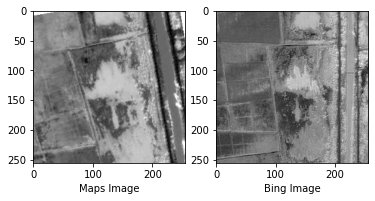

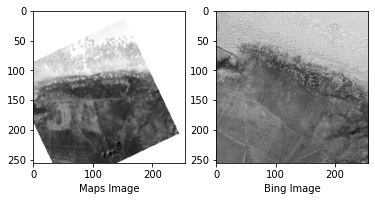

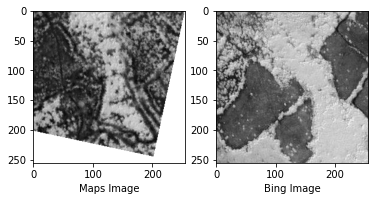

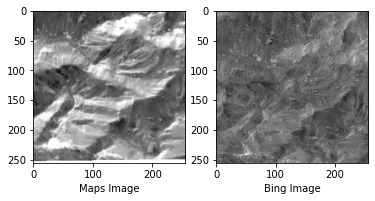

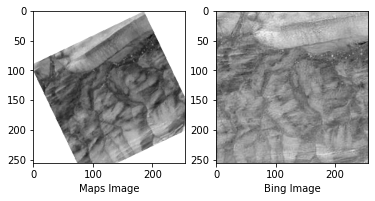

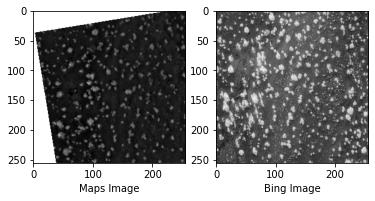

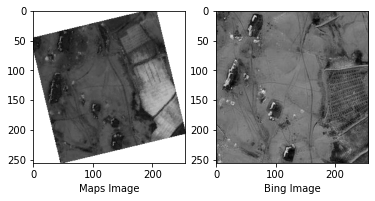

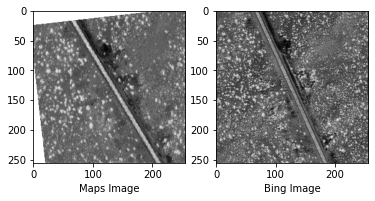

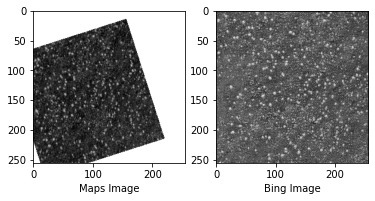

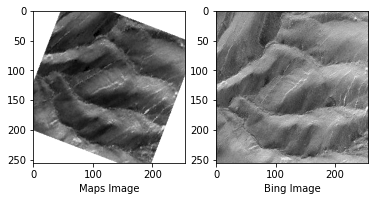

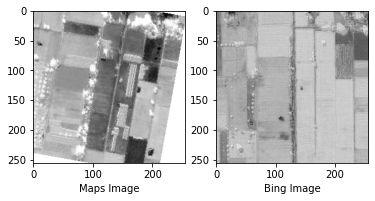

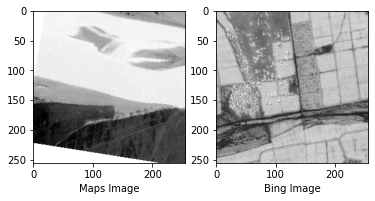

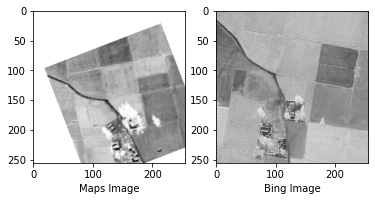

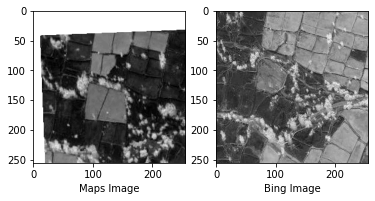

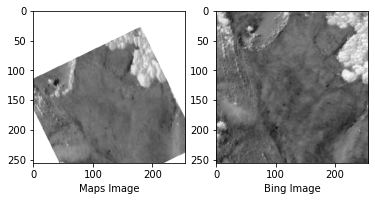

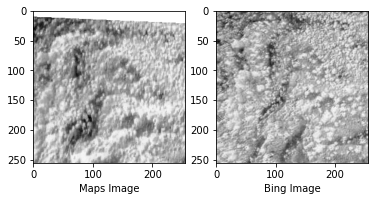

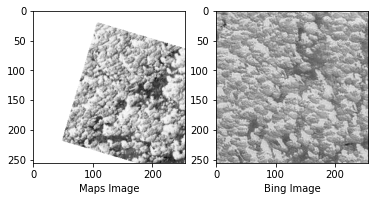

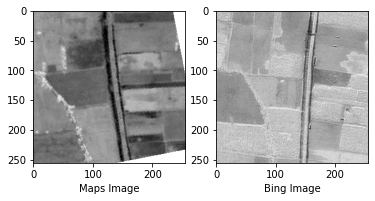

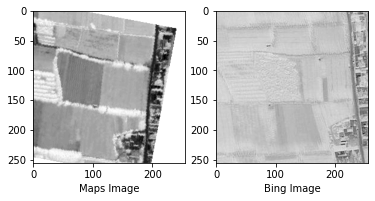

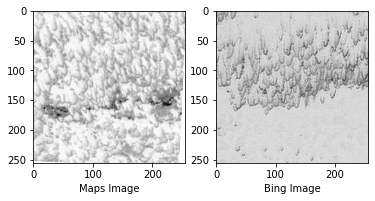

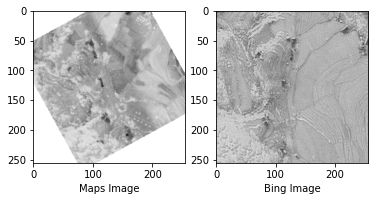

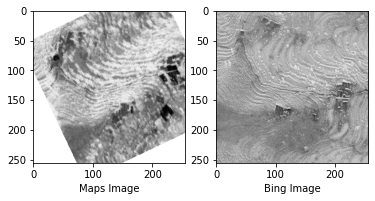

In [5]:
criterion = nn.MSELoss()

for data_bing, data_maps in zip(train_loader_bing, train_loader_maps):
    images_bing, _ = data_bing
    images_maps, _ = data_maps
    
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(images_maps[2,0], cmap=cm.binary)
    axes[0].set_xlabel("Maps Image")
    axes[1].imshow(images_bing[2,0], cmap=cm.binary)
    axes[1].set_xlabel("Bing Image")
    
#     loss = criterion(images_bing, images_maps)
#     print(loss)

In [4]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)

    def forward(self, x):
        print(".", end = '')
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)        
        x = F.relu(self.t_conv1(x))
        x = torch.sigmoid(self.t_conv2(x))

        return x

In [7]:
model = ConvAutoencoder()
# model.load_state_dict(torch.load("model_30.pth"))
# print("Loaded model")

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
n_epochs = 2

.....................

<ipython-input-16-7dfc4f149848>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, 2)


.Epoch: 1 	Training Loss: 1.168753
......................Epoch: 2 	Training Loss: 1.119461


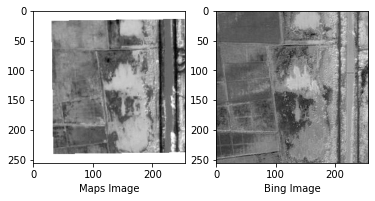

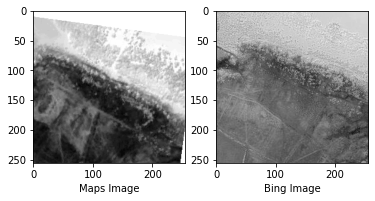

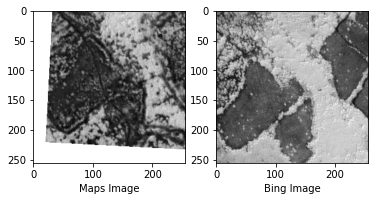

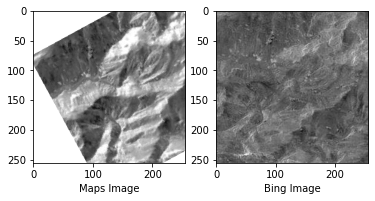

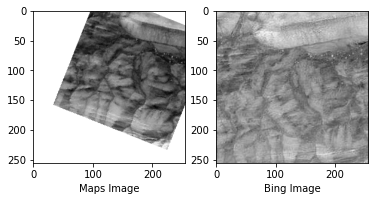

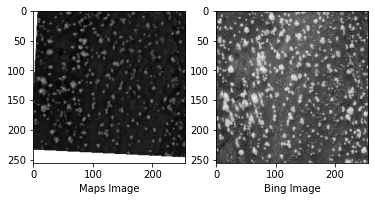

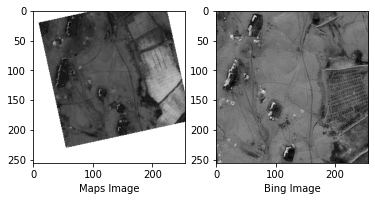

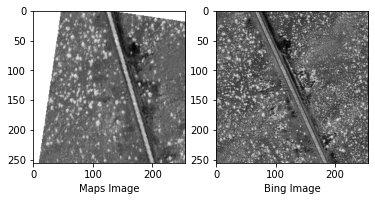

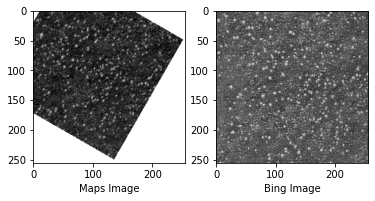

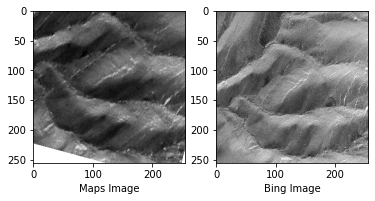

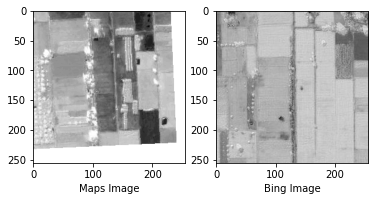

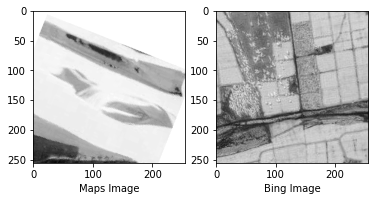

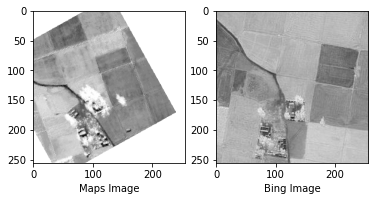

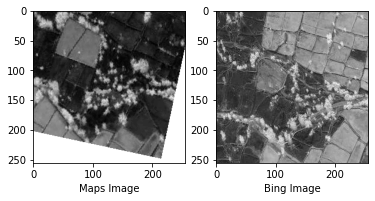

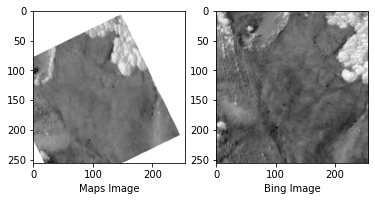

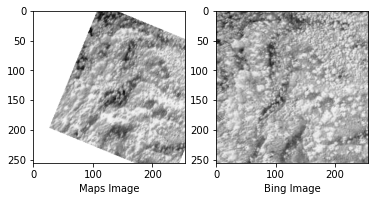

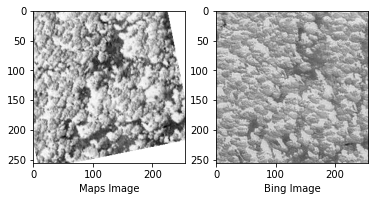

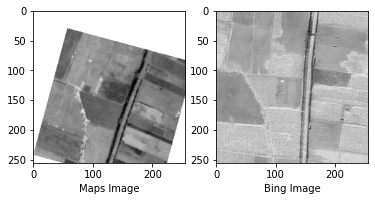

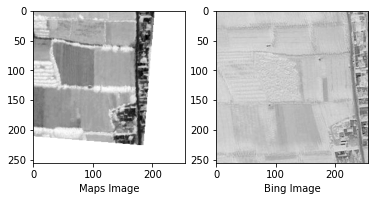

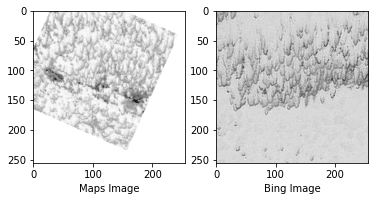

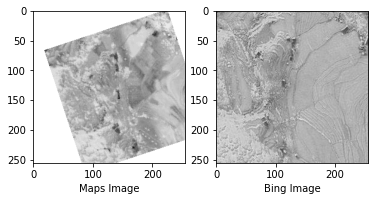

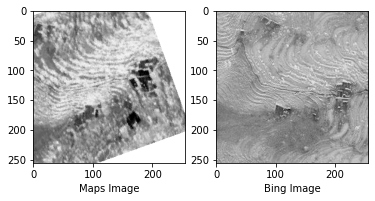

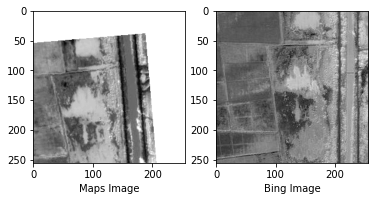

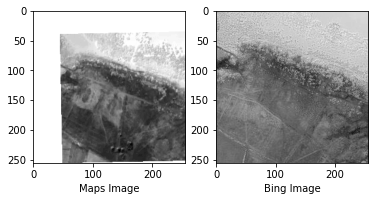

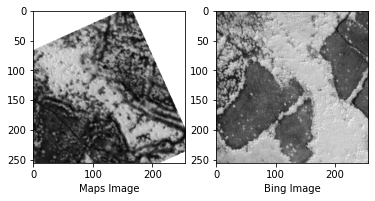

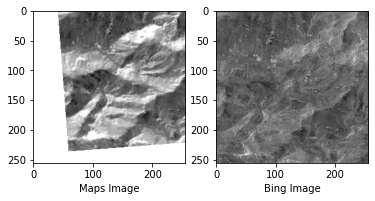

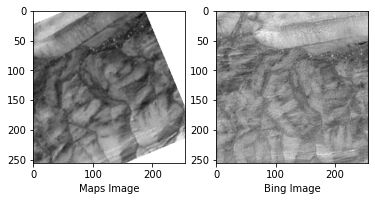

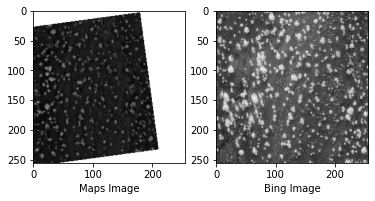

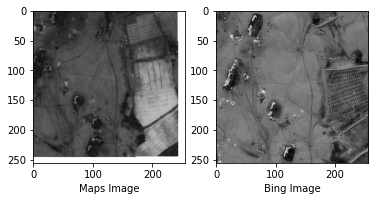

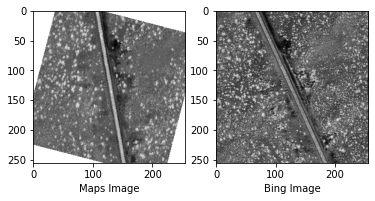

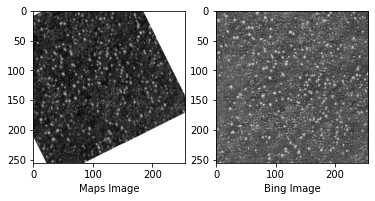

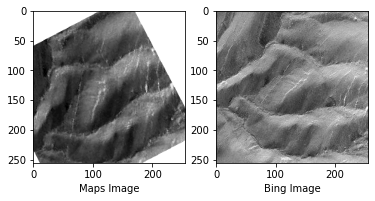

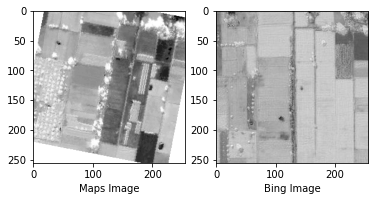

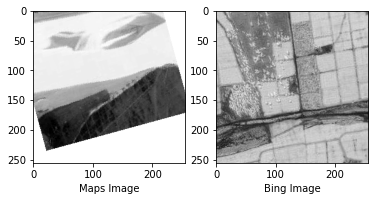

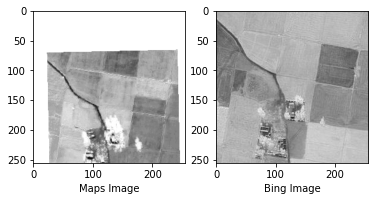

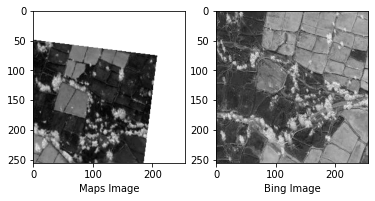

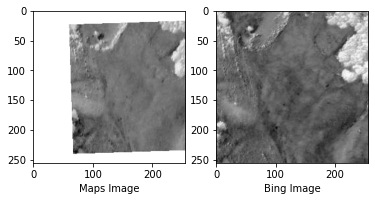

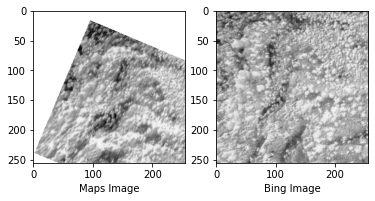

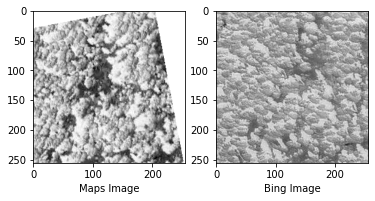

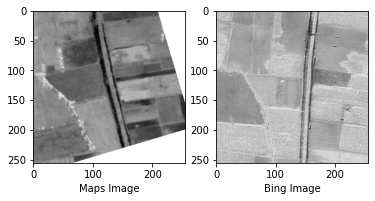

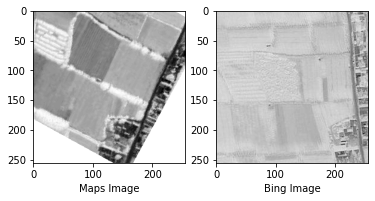

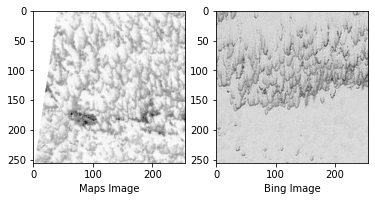

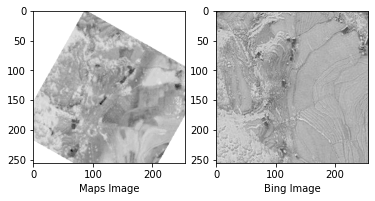

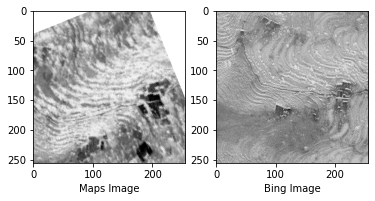

In [16]:
for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    for data_maps, data_bing in zip(train_loader_maps, train_loader_bing):
        images, _ = data_maps
        labels, _ = data_bing
        
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
        
    train_loss = train_loss/len(train_loader_maps)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

    torch.save(model.state_dict(), os.path.join('models/model_{}.pth'.format(epoch)))